## Seizure Detection Challenge (2025) 

This notebook implements a seizure detection pipeline using EEG data from the BIDS-formatted Siena Scalp EEG Dataset. We'll go through the following steps:

#### 1. Data loading and preprocessing
#### 2. Creating a PyTorch dataset
#### 3. Building and training a CNN model
#### 4. Evaluating the results


In [20]:
#Imports
import mne
import mne_bids
from bids import BIDSLayout
import numpy as np
import pandas as pd
from pathlib import Path
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import logging
from typing import Tuple, List, Optional

# Set the maximum number of columns to display
pd.set_option('display.max_columns', None) 

import warnings
warnings.filterwarnings("ignore")

In [21]:
# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S'
)
logger = logging.getLogger(__name__)

### Exploratory Data Analysis

In [22]:
#BIDS_Siena Sub 00 ses-01 run 00
sub00ses01run00 = r"C:\Users\user\Documents\eeg_data_challenge\BIDS_Siena\BIDS_Siena\sub-00\ses-01\eeg\sub-00_ses-01_task-szMonitoring_run-00_eeg.edf"
sub00ses01run00 = mne.io.read_raw_edf(sub00ses01run00, preload=True)
print(sub00ses01run00.info)

Extracting EDF parameters from C:\Users\user\Documents\eeg_data_challenge\BIDS_Siena\BIDS_Siena\sub-00\ses-01\eeg\sub-00_ses-01_task-szMonitoring_run-00_eeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 671999  =      0.000 ...  2624.996 secs...
<Info | 8 non-empty values
 bads: []
 ch_names: Fp1-Avg, F3-Avg, C3-Avg, P3-Avg, O1-Avg, F7-Avg, T3-Avg, T5-Avg, ...
 chs: 19 EEG
 custom_ref_applied: False
 highpass: 1.6 Hz
 lowpass: 30.0 Hz
 meas_date: 2016-01-01 19:39:33 UTC
 nchan: 19
 projs: []
 sfreq: 256.0 Hz
 subject_info: 3 items (dict)
>


In [23]:
#View Channel Names
print(sub00ses01run00.ch_names)

['Fp1-Avg', 'F3-Avg', 'C3-Avg', 'P3-Avg', 'O1-Avg', 'F7-Avg', 'T3-Avg', 'T5-Avg', 'Fz-Avg', 'Cz-Avg', 'Pz-Avg', 'Fp2-Avg', 'F4-Avg', 'C4-Avg', 'P4-Avg', 'O2-Avg', 'F8-Avg', 'T4-Avg', 'T6-Avg']


In [24]:
sub00ses01run00.plot(duration=10, n_channels=19)

In [25]:
# Extract EEG data as a NumPy array
eeg_data = sub00ses01run00.get_data()
channel_names = sub00ses01run00.ch_names

# Compute basic statistics
eeg_stats = pd.DataFrame({
    "Channel": channel_names,
    "Mean": np.mean(eeg_data, axis=1),
    "Std Dev": np.std(eeg_data, axis=1),
    "Min": np.min(eeg_data, axis=1),
    "Max": np.max(eeg_data, axis=1)
})

# Display the computed statistics
print(eeg_stats)


    Channel          Mean   Std Dev       Min       Max
0   Fp1-Avg -4.934503e-07  0.000049 -0.000430  0.001162
1    F3-Avg  1.461965e-08  0.000020 -0.000239  0.000494
2    C3-Avg -2.182140e-06  0.000016 -0.000343  0.000216
3    P3-Avg -1.308922e-06  0.000026 -0.000308  0.000950
4    O1-Avg -1.614275e-06  0.000095 -0.001081  0.002979
5    F7-Avg  1.795892e-06  0.000035 -0.000349  0.000406
6    T3-Avg -4.000901e-07  0.000022 -0.000466  0.000198
7    T5-Avg  3.125583e-06  0.000018 -0.000402  0.000203
8    Fz-Avg  4.814427e-07  0.000019 -0.000217  0.000315
9    Cz-Avg -4.819394e-06  0.000041 -0.000250  0.001165
10   Pz-Avg -1.682614e-06  0.000036 -0.000280  0.001136
11  Fp2-Avg  2.336533e-06  0.000055 -0.000461  0.001377
12   F4-Avg -4.353400e-07  0.000021 -0.000211  0.000637
13   C4-Avg -2.405176e-06  0.000017 -0.000202  0.000224
14   P4-Avg  9.287732e-07  0.000017 -0.000206  0.000174
15   O2-Avg  6.411352e-07  0.000026 -0.000304  0.000235
16   F8-Avg  2.965402e-06  0.000044 -0.000449  0

Computes the mean, standard deviation, min and max values for each EEG channel.

Helps in detecting anomalies, identifying bad channels and understanding the data distribution.

In [26]:
#Loading Seizure Annotations
sub00ses01run00_annotations = r"C:\Users\user\Documents\eeg_data_challenge\BIDS_Siena\BIDS_Siena\sub-00\ses-01\eeg\sub-00_ses-01_task-szMonitoring_run-00_events.tsv"
sub00ses01run00_annotations = pd.read_csv(sub00ses01run00_annotations, sep='\t')
print(sub00ses01run00_annotations.head())

    onset  duration  eventType  confidence channels             dateTime  \
0  1143.0      70.0  sz_foc_ia         NaN    T4,T6  2016-01-01 19:39:33   

   recordingDuration  
0             2625.0  


In [27]:
# Create MNE Annotations object
mne_annotations = mne.Annotations(
    onset=sub00ses01run00_annotations["onset"].values,
    duration=sub00ses01run00_annotations["duration"].values,
    description=sub00ses01run00_annotations["eventType"].values
)

# Set annotations to the raw EEG object
sub00ses01run00.set_annotations(mne_annotations)

# Plot EEG data with annotations
sub00ses01run00.plot()

# Print first few rows of the annotations DataFrame
print(sub00ses01run00_annotations.head())

    onset  duration  eventType  confidence channels             dateTime  \
0  1143.0      70.0  sz_foc_ia         NaN    T4,T6  2016-01-01 19:39:33   

   recordingDuration  
0             2625.0  


Electrode Labels on the left
    - These are the the EEG channel names corresponding to the standard 10-20 system electrode placements
EEG Signal Traces
    -Each Channel shows its recorded electrical activity over time in microvolts (µV). These signals represent the brain activity, and you may observe rhythmic patterns, spikes, or artifacts.
Time Axis (x-axis)

Highlighted Blue
    -Added Annotation (probably start and duration of seizure event)

#### Data Handling Classes and Functions
- Define our custom Dataset class for handling EEG data and our path verification function.

In [28]:
class SeizureDataset(Dataset):
    """
    Custom Dataset for handling EEG seizure data.
    Converts numpy arrays to PyTorch tensors and provides standard dataset functionality.
    """
    def __init__(self, X: np.ndarray, y: np.ndarray):
        self.X = torch.FloatTensor(X)
        self.y = torch.FloatTensor(y)
        
    def __len__(self) -> int:
        return len(self.X)
    
    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
        return self.X[idx], self.y[idx]

def verify_paths(bids_root: Path) -> Path:
    """
    Verify and construct the correct path to the BIDS dataset.
    Handles the nested BIDS_Siena directory structure.
    """
    bids_root = Path(bids_root)
    actual_bids_root = bids_root / "BIDS_Siena"
    
    if not actual_bids_root.exists():
        raise FileNotFoundError(
            f"BIDS directory not found at: {actual_bids_root}\n"
            f"Please check if the path is correct."
        )
    
    logger.info(f"Verified BIDS directory at: {actual_bids_root}")
    return actual_bids_root

#### Data Loading and Processing Functions
- Implement functions to load and process our EEG recordings. We'll add comprehensive metrics calculation.

In [29]:
def load_single_recording(
    eeg_file: Path,
    events_file: Path,
    window_size: int = 256,
    overlap: float = 0.5
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Load and process a single EEG recording with its corresponding events.
    The data is windowed and labeled according to seizure events.
    """
    try:
        # Load EEG data
        logger.info(f"Loading EEG file: {eeg_file.name}")
        raw = mne.io.read_raw_edf(eeg_file, preload=True)
        
        # Load events
        logger.info(f"Loading events from: {events_file.name}")
        events_df = pd.read_csv(events_file, sep='\t')
        
        # Get EEG data and parameters
        data = raw.get_data()
        sfreq = raw.info['sfreq']
        
        # Calculate windowing parameters
        stride = int(window_size * (1 - overlap))
        n_windows = (data.shape[1] - window_size) // stride + 1
        
        # Initialize arrays
        windows = np.zeros((n_windows, data.shape[0], window_size))
        labels = np.zeros(n_windows)
        
        # Process each window
        for i in range(n_windows):
            start_idx = i * stride
            end_idx = start_idx + window_size
            windows[i] = data[:, start_idx:end_idx]
            
            # Convert to time
            window_start_time = start_idx / sfreq
            window_end_time = end_idx / sfreq
            
            # Check for seizure events
            for _, event in events_df.iterrows():
                if event['eventType'].startswith('sz'):
                    event_start = event['onset']
                    event_end = event_start + event['duration']
                    
                    if (window_start_time <= event_end and 
                        window_end_time >= event_start):
                        labels[i] = 1
                        break
        
        logger.info(f"Processed {n_windows} windows from {eeg_file.name}")
        return windows, labels
    
    except Exception as e:
        logger.error(f"Error processing {eeg_file}: {str(e)}")
        raise

#### Dataset Preparation
- Function to prepare our dataset from a single subject's recordings.

In [30]:
def prepare_test_dataset(bids_root: Path, subject_id: str = "00") -> Tuple[np.ndarray, np.ndarray]:
    """
    Prepare the initial test dataset using data from a single subject.
    """
    try:
        subject_dir = bids_root / f"sub-{subject_id}" / "ses-01" / "eeg"
        logger.info(f"Processing subject directory: {subject_dir}")
        
        if not subject_dir.exists():
            raise FileNotFoundError(f"Subject directory not found: {subject_dir}")
        
        all_data = []
        all_labels = []
        
        # Find all EEG files
        eeg_files = list(subject_dir.glob("*_eeg.edf"))
        logger.info(f"Found {len(eeg_files)} EEG files")
        
        for eeg_file in eeg_files:
            events_file = eeg_file.parent / eeg_file.name.replace("_eeg.edf", "_events.tsv")
            
            if not events_file.exists():
                logger.warning(f"Events file not found: {events_file}")
                continue
                
            try:
                data, labels = load_single_recording(eeg_file, events_file)
                logger.info(f"Successfully loaded data with shape {data.shape}")
                all_data.append(data)
                all_labels.append(labels)
            except Exception as e:
                logger.error(f"Error processing file {eeg_file}: {str(e)}")
                continue
        
        if not all_data:
            raise ValueError("No data was successfully loaded")
            
        X = np.concatenate(all_data)
        y = np.concatenate(all_labels)
        
        logger.info(f"Final dataset shape: {X.shape}")
        return X, y
    
    except Exception as e:
        logger.error(f"Error preparing dataset: {str(e)}")
        raise

#### Model Architecture
- Define CNN model for seizure detection.

In [31]:
class SeizureDetectionModel(nn.Module):
    """
    CNN model for seizure detection in EEG data.
    Uses 3 convolutional layers with batch normalization and max pooling,
    followed by fully connected layers for classification.
    """
    def __init__(self, n_channels: int, n_classes: int = 1):
        super().__init__()
        
        self.feature_extractor = nn.Sequential(
            # First conv block
            nn.Conv1d(n_channels, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm1d(32),
            nn.MaxPool1d(2),
            
            # Second conv block
            nn.Conv1d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.MaxPool1d(2),
            
            # Third conv block
            nn.Conv1d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.MaxPool1d(2),
        )
        
        self.flatten_size = self._get_flatten_size(n_channels)
        
        self.classifier = nn.Sequential(
            nn.Linear(self.flatten_size, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, n_classes)
        )
    
    def _get_flatten_size(self, n_channels: int) -> int:
        x = torch.randn(1, n_channels, 256)
        x = self.feature_extractor(x)
        return x.view(1, -1).size(1)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.feature_extractor(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

#### Training and Evaluation Functions
- Implement training functions and metrics evaluation

In [32]:
def calculate_metrics(predictions: torch.Tensor, targets: torch.Tensor) -> Tuple[float, float, float]:
    """
    Calculate precision, recall, and F1 score for binary classification.
    """
    predictions = predictions.cpu().numpy()
    targets = targets.cpu().numpy()
    
    true_positives = ((predictions == 1) & (targets == 1)).sum()
    predicted_positives = (predictions == 1).sum()
    actual_positives = (targets == 1).sum()
    
    precision = true_positives / predicted_positives if predicted_positives > 0 else 0
    recall = true_positives / actual_positives if actual_positives > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    return precision, recall, f1

def validate(
    model: nn.Module,
    val_loader: DataLoader,
    criterion: nn.Module,
    device: torch.device
) -> Tuple[float, float, float, float]:
    """
    Validate the model and calculate comprehensive metrics.
    
    Args:
        model: The neural network model
        val_loader: DataLoader for validation data
        criterion: Loss function
        device: Computing device (CPU/GPU)
    
    Returns:
        Tuple containing:
        - validation loss (float)
        - precision (float)
        - recall (float)
        - F1 score (float)
    """
    model.eval()  # Set model to evaluation mode
    total_loss = 0
    all_preds = []
    all_targets = []
    
    # No gradient computation needed for validation
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            # Move data to appropriate device
            batch_X = batch_X.to(device)
            batch_y = batch_y.to(device)
            
            # Forward pass
            outputs = model(batch_X)
            loss = criterion(outputs.squeeze(), batch_y)
            
            # Accumulate loss
            total_loss += loss.item()
            
            # Get predictions
            predictions = (torch.sigmoid(outputs.squeeze()) > 0.5).float()
            
            # Store predictions and targets for metric calculation
            all_preds.extend(predictions.cpu().numpy())
            all_targets.extend(batch_y.cpu().numpy())
    
    # Calculate metrics
    all_preds = np.array(all_preds)
    all_targets = np.array(all_targets)
    
    # Calculate precision
    precision = np.sum((all_preds == 1) & (all_targets == 1)) / (np.sum(all_preds == 1) + 1e-10)
    
    # Calculate recall
    recall = np.sum((all_preds == 1) & (all_targets == 1)) / (np.sum(all_targets == 1) + 1e-10)
    
    # Calculate F1 score
    f1 = 2 * (precision * recall) / (precision + recall + 1e-10)
    
    # Return average loss and metrics
    return total_loss / len(val_loader), precision, recall, f1

def train_epoch(
    model: nn.Module,
    train_loader: DataLoader,
    criterion: nn.Module,
    optimizer: torch.optim.Optimizer,
    device: torch.device
) -> Tuple[float, float, float, float]:
    """
    Train the model for one epoch and return metrics.
    """
    model.train()
    total_loss = 0
    all_preds = []
    all_targets = []
    
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs.squeeze(), batch_y)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
        # Store predictions and targets for metrics
        predictions = (torch.sigmoid(outputs.squeeze()) > 0.5).float()
        all_preds.extend(predictions.tolist())
        all_targets.extend(batch_y.tolist())
    
    # Calculate metrics
    precision, recall, f1 = calculate_metrics(
        torch.tensor(all_preds),
        torch.tensor(all_targets)
    )
    
    return total_loss / len(train_loader), precision, recall, f1


#### Main Training loop

2025-02-22 17:22:58 - INFO - Verified BIDS directory at: C:\Users\user\Documents\eeg_data_challenge\BIDS_Siena\BIDS_Siena
2025-02-22 17:22:58 - INFO - Loading test dataset...
2025-02-22 17:22:58 - INFO - Processing subject directory: C:\Users\user\Documents\eeg_data_challenge\BIDS_Siena\BIDS_Siena\sub-00\ses-01\eeg
2025-02-22 17:22:58 - INFO - Found 5 EEG files
2025-02-22 17:22:58 - INFO - Loading EEG file: sub-00_ses-01_task-szMonitoring_run-00_eeg.edf


Extracting EDF parameters from C:\Users\user\Documents\eeg_data_challenge\BIDS_Siena\BIDS_Siena\sub-00\ses-01\eeg\sub-00_ses-01_task-szMonitoring_run-00_eeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 671999  =      0.000 ...  2624.996 secs...


2025-02-22 17:22:59 - INFO - Loading events from: sub-00_ses-01_task-szMonitoring_run-00_events.tsv
2025-02-22 17:23:03 - INFO - Processed 5249 windows from sub-00_ses-01_task-szMonitoring_run-00_eeg.edf
2025-02-22 17:23:03 - INFO - Successfully loaded data with shape (5249, 19, 256)
2025-02-22 17:23:03 - INFO - Loading EEG file: sub-00_ses-01_task-szMonitoring_run-01_eeg.edf


Extracting EDF parameters from C:\Users\user\Documents\eeg_data_challenge\BIDS_Siena\BIDS_Siena\sub-00\ses-01\eeg\sub-00_ses-01_task-szMonitoring_run-01_eeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 589311  =      0.000 ...  2301.996 secs...


2025-02-22 17:23:04 - INFO - Loading events from: sub-00_ses-01_task-szMonitoring_run-01_events.tsv
2025-02-22 17:23:07 - INFO - Processed 4603 windows from sub-00_ses-01_task-szMonitoring_run-01_eeg.edf
2025-02-22 17:23:07 - INFO - Successfully loaded data with shape (4603, 19, 256)
2025-02-22 17:23:07 - INFO - Loading EEG file: sub-00_ses-01_task-szMonitoring_run-02_eeg.edf


Extracting EDF parameters from C:\Users\user\Documents\eeg_data_challenge\BIDS_Siena\BIDS_Siena\sub-00\ses-01\eeg\sub-00_ses-01_task-szMonitoring_run-02_eeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 642303  =      0.000 ...  2508.996 secs...


2025-02-22 17:23:07 - INFO - Loading events from: sub-00_ses-01_task-szMonitoring_run-02_events.tsv
2025-02-22 17:23:11 - INFO - Processed 5017 windows from sub-00_ses-01_task-szMonitoring_run-02_eeg.edf
2025-02-22 17:23:11 - INFO - Successfully loaded data with shape (5017, 19, 256)
2025-02-22 17:23:11 - INFO - Loading EEG file: sub-00_ses-01_task-szMonitoring_run-03_eeg.edf


Extracting EDF parameters from C:\Users\user\Documents\eeg_data_challenge\BIDS_Siena\BIDS_Siena\sub-00\ses-01\eeg\sub-00_ses-01_task-szMonitoring_run-03_eeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 538111  =      0.000 ...  2101.996 secs...


2025-02-22 17:23:11 - INFO - Loading events from: sub-00_ses-01_task-szMonitoring_run-03_events.tsv
2025-02-22 17:23:13 - INFO - Processed 4203 windows from sub-00_ses-01_task-szMonitoring_run-03_eeg.edf
2025-02-22 17:23:13 - INFO - Successfully loaded data with shape (4203, 19, 256)
2025-02-22 17:23:13 - INFO - Loading EEG file: sub-00_ses-01_task-szMonitoring_run-04_eeg.edf


Extracting EDF parameters from C:\Users\user\Documents\eeg_data_challenge\BIDS_Siena\BIDS_Siena\sub-00\ses-01\eeg\sub-00_ses-01_task-szMonitoring_run-04_eeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 548607  =      0.000 ...  2142.996 secs...


2025-02-22 17:23:14 - INFO - Loading events from: sub-00_ses-01_task-szMonitoring_run-04_events.tsv
2025-02-22 17:23:17 - INFO - Processed 4285 windows from sub-00_ses-01_task-szMonitoring_run-04_eeg.edf
2025-02-22 17:23:17 - INFO - Successfully loaded data with shape (4285, 19, 256)
2025-02-22 17:23:19 - INFO - Final dataset shape: (23357, 19, 256)
2025-02-22 17:23:19 - INFO - Class weight for positive class: 34.12
2025-02-22 17:23:19 - INFO - Dataset loaded: 23357 windows
2025-02-22 17:23:19 - INFO - Seizure windows: 665 (2.85%)
2025-02-22 17:23:20 - INFO - Training set size: 18685, Validation set size: 4672
2025-02-22 17:23:20 - INFO - Using device: cpu
2025-02-22 17:23:20 - INFO - Starting training...
2025-02-22 17:24:05 - INFO - Epoch 1/10
2025-02-22 17:24:05 - INFO - Train Loss: 1.4264, F1: 0.1731
2025-02-22 17:24:05 - INFO - Val Loss: 116.0956, F1: 0.0554
2025-02-22 17:24:05 - INFO - Saved new best model
2025-02-22 17:24:50 - INFO - Epoch 2/10
2025-02-22 17:24:50 - INFO - Train 

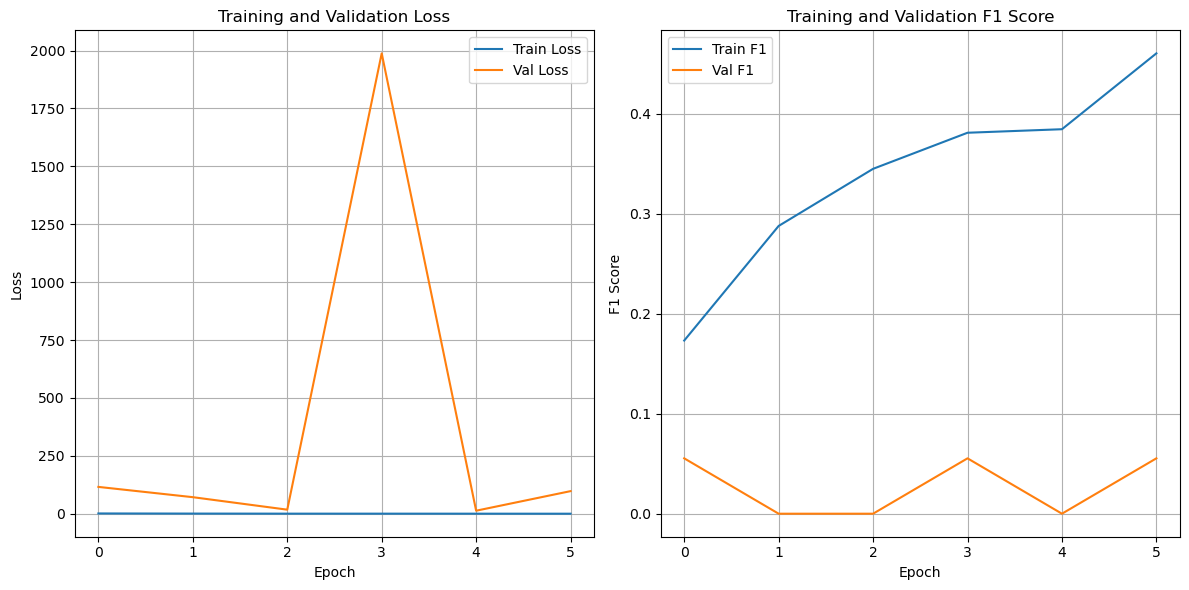

Channels marked as bad:
none
Attempting to create new mne-python configuration file:
C:\Users\user\.mne\mne-python.json
Channels marked as bad:
none
Channels marked as bad:
none
Channels marked as bad:
none


In [ ]:
def main():
    """Main function to run the seizure detection pipeline"""
    try:
        # Set up paths
        initial_path = Path(r"C:\Users\user\Documents\eeg_data_challenge\BIDS_Siena")
        bids_root = verify_paths(initial_path)
        
        # Load dataset
        logger.info("Loading test dataset...")
        X, y = prepare_test_dataset(bids_root)
        
        # Calculate class weights for imbalanced dataset
        pos_weight = torch.tensor([(y == 0).sum() / (y == 1).sum()])
        logger.info(f"Class weight for positive class: {pos_weight.item():.2f}")
        
        # Print dataset statistics
        logger.info(f"Dataset loaded: {X.shape[0]} windows")
        logger.info(f"Seizure windows: {np.sum(y == 1)} ({np.mean(y == 1)*100:.2f}%)")
        
        # Split data
        X_train, X_val, y_train, y_val = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )
        logger.info(f"Training set size: {len(X_train)}, Validation set size: {len(X_val)}")
        
        # Create data loaders
        train_dataset = SeizureDataset(X_train, y_train)
        val_dataset = SeizureDataset(X_val, y_val)
        
        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=32)
        
        # Set up device
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        logger.info(f"Using device: {device}")
        
        # Initialize model and training components
        model = SeizureDetectionModel(n_channels=19).to(device)
        criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        
        # Training parameters
        n_epochs = 10
        best_val_f1 = 0
        patience = 5  # Added early stopping patience
        patience_counter = 0
        
        # Lists to store metrics for plotting
        train_losses = []
        val_losses = []
        train_f1s = []
        val_f1s = []
        
        # Training loop
        logger.info("Starting training...")
        for epoch in range(n_epochs):
            # Train
            train_loss, train_prec, train_rec, train_f1 = train_epoch(
                model, train_loader, criterion, optimizer, device
            )
            
            # Validate
            val_loss, val_prec, val_rec, val_f1 = validate(
                model, val_loader, criterion, device
            )
            
            # Store metrics
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            train_f1s.append(train_f1)
            val_f1s.append(val_f1)
            
            # Log progress
            logger.info(f"Epoch {epoch+1}/{n_epochs}")
            logger.info(f"Train Loss: {train_loss:.4f}, F1: {train_f1:.4f}")
            logger.info(f"Val Loss: {val_loss:.4f}, F1: {val_f1:.4f}")
            
            # Save best model based on F1 score
            if val_f1 > best_val_f1:
                best_val_f1 = val_f1
                # Save more comprehensive checkpoint
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'train_loss': train_loss,
                    'val_loss': val_loss,
                    'val_f1': val_f1,
                    'best_f1': best_val_f1,
                }, 'best_model.pth')
                logger.info("Saved new best model")
                patience_counter = 0
            else:
                patience_counter += 1
            
            # Early stopping
            if patience_counter >= patience:
                logger.info(f"Early stopping triggered after {epoch+1} epochs")
                break
        
        logger.info("Training complete")
        
        # Plot training and validation metrics
        plt.figure(figsize=(12, 6))
        
        # Loss plot
        plt.subplot(1, 2, 1)
        plt.plot(train_losses, label='Train Loss')
        plt.plot(val_losses, label='Val Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss')
        plt.legend()
        plt.grid(True)
        
        # F1 score plot
        plt.subplot(1, 2, 2)
        plt.plot(train_f1s, label='Train F1')
        plt.plot(val_f1s, label='Val F1')
        plt.xlabel('Epoch')
        plt.ylabel('F1 Score')
        plt.title('Training and Validation F1 Score')
        plt.legend()
        plt.grid(True)
        
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        logger.error(f"Error in main: {str(e)}")
        raise

if __name__ == "__main__":
    main()